#Section 1: Importing Modules and Data

This section involves importing the necessary libraries, loading the training and testing datasets, and preprocessing the target variable. The class labels in the response have been converted to binary, where `0 = "healthy"` & `1 = "cancer"`. The data is then split into feature sets and response variables for both training and testing.
* `train_x` contains the training features
* `train_y` represents the training response variable
* `test_x` contains the testing features
* `test_y` represents the testing response variable

In [ ]:
# Install necessary packages
#!pip install kneed

# Data manipulation and analysis
import pandas as pd
import numpy as np
import random

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve, average_precision_score, auc, roc_curve, roc_auc_score, balanced_accuracy_score

# Handling imbalanced datasets
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Knee locator to find elbow of curve
from kneed import KneeLocator

# Statistical functions
import scipy
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import median_abs_deviation
from scipy.stats import pointbiserialr

# Set Seed for Reproducibility
np.random.seed(1244)
random.seed(1244)

# Importing train and test data
train_data = pd.read_csv("data/Train_Set.csv")
test_data = pd.read_csv("data/Test_Set.csv")

# Convert binary values in the response variable
train_data['class_label'] = train_data['class_label'].replace({'cancer': 1, 'healthy': 0})
test_data['class_label'] = test_data['class_label'].replace({'cancer': 1, 'healthy': 0})

# Split Into Feature vs Results
train_x = train_data.iloc[:, :-1]  # training features
train_y = train_data['class_label']  # testing response
test_x = test_data.iloc[:, :-1] # testing features
test_y = test_data['class_label'] # testing response

<ipython-input-1-b8f57e657e2d>:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['class_label'] = train_data['class_label'].replace({'cancer': 1, 'healthy': 0})
<ipython-input-1-b8f57e657e2d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data['class_label'] = test_data['class_label'].replace({'cancer': 1, 'healthy': 0})


# Section 2: Feature Selection

###2a: Choice of Feature Scaling

In this section, we assess the need for feature scaling. The violin plot of feature means reveals significant variation, justifying the need for feature scaling. Outlier detection using modified Z-scores identifies 210 features with extreme outliers, further supporting the choice of standardization over normalization.

* `final_summary` contains the outlier categories and their corresponding feature counts.



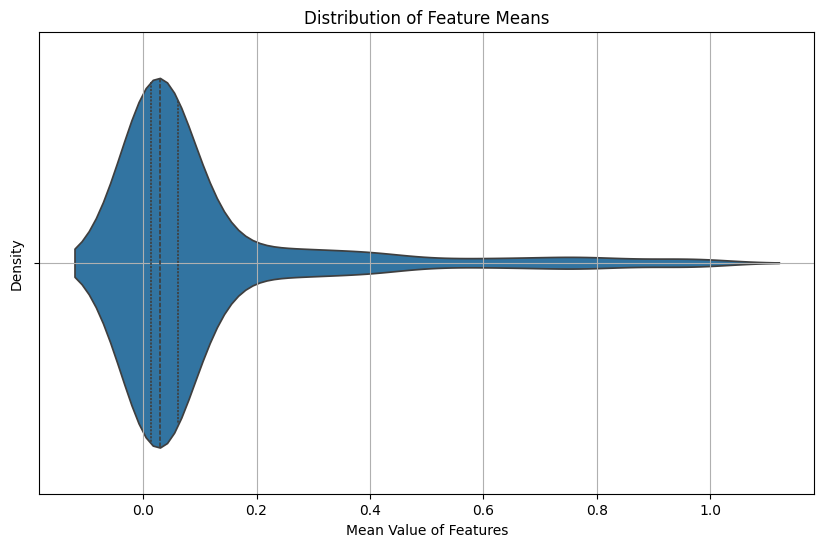

Outlier Summary using Modified Z-score:
  Outlier Category  Feature Count
0    High Outliers            210
1     Low Outliers            140


In [ ]:
# Data Visualization to Check the Distribution of Feature Means
plt.figure(figsize=(10, 6))
sns.violinplot(x=train_x.mean(), inner="quartile", orient="h")
plt.title('Distribution of Feature Means')
plt.xlabel('Mean Value of Features')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Function to Calculate Modified Z-score
def modified_zscore(data):
    """Calculate the modified Z-score for each feature in the dataset."""
    medians = np.median(data, axis=0)  # Calculate the median for each feature
    mad_values = median_abs_deviation(data, axis=0)  # Calculate Median Absolute Deviation (MAD)
    modified_z = 0.6745 * (data - medians) / mad_values  # Calculate the modified Z-score
    return np.abs(modified_z)  # Return the absolute values of the modified Z-scores

# Apply Modified Z-score
modified_z_scores = modified_zscore(train_x)

# Count the Number of Outliers for Each Feature
outlier_summary = pd.DataFrame({
    'Feature': train_x.columns,  # List of features
    'Count_ModZ<3': np.sum(modified_z_scores < 3, axis=0),    # Count non-outliers (Modified Z-score < 3)
    'Count_ModZ>=3': np.sum(modified_z_scores >= 3, axis=0)   # Count outliers (Modified Z-score >= 3)
})

# Define Threshold for "High" Number of Outliers (>1% of Samples)
threshold_high = 8  # 1% of 841 samples

# Separate Features into "High Outliers" and "Low Outliers"
high_outliers = outlier_summary[outlier_summary['Count_ModZ>=3'] >= threshold_high]
low_outliers = outlier_summary[outlier_summary['Count_ModZ>=3'] < threshold_high]

# Summary of Outliers
final_summary = pd.DataFrame({
    'Outlier Category': ['High Outliers', 'Low Outliers'],
    'Feature Count': [high_outliers.shape[0], low_outliers.shape[0]]
})

print("Outlier Summary using Modified Z-score:")
print(final_summary)


### 2b: Standardizing Features
In this section, we standardize the training and testing datasets to ensure that all features contribute equally to processes that use similarity measures (like PCA or SVM). The `StandardScaler` is employed to scale the training data, and the same scaling parameters are applied to the testing data.
* `train_x_scaled` contains the standardized training features
* `test_x_scaled` contains the standardized testing features, transformed using the same parameters as the training data.


In [ ]:
# Standardize the training data
scaler = StandardScaler() # The StandardScaler from sklearn.preprocessing does standardization
train_x_scaled = scaler.fit_transform(train_x)
train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x.columns)

# Standardize the testing data using the same parameters from the training data
test_x_scaled = scaler.transform(test_x)
test_x_scaled = pd.DataFrame(test_x_scaled, columns=test_x.columns)

# Check the shapes of the standardized data
print("Shape of standardized training data:", train_x_scaled.shape)
print("Shape of standardized testing data:", test_x_scaled.shape)

# Check the means and standard deviations of the standardized training data
print("Mean of standardized training data:", train_x_scaled.mean())
print("Standard deviation of standardized training data:", train_x_scaled.std())

Shape of standardized training data: (841, 350)
Shape of standardized testing data: (409, 350)
Mean of standardized training data: length_51    -1.689757e-16
length_52     1.689757e-16
length_53    -3.379514e-17
length_54    -1.182830e-16
length_55    -2.534635e-16
                  ...     
length_396   -1.267318e-16
length_397   -6.759027e-17
length_398    2.788099e-16
length_399    1.689757e-17
length_400   -1.182830e-16
Length: 350, dtype: float64
Standard deviation of standardized training data: length_51     1.000595
length_52     1.000595
length_53     1.000595
length_54     1.000595
length_55     1.000595
                ...   
length_396    1.000595
length_397    1.000595
length_398    1.000595
length_399    1.000595
length_400    1.000595
Length: 350, dtype: float64


### 2c: PCA and Feature Selection by Explained Variance
This code block performs PCA on the scaled training data to determine the number of components needed to capture 99.99% of the variance. After calculating cumulative variance, we identify the minimum number of components required to meet this threshold. We store the explained variance for these components in a DataFrame and generate a plot of explained variance by component. Using the KneeLocator method, we find the "elbow" point, which indicates where the variance contribution starts to level off, providing a basis for selecting components for further analysis.

* `pca_variance_df` contains the 75 PCs along with their respective explained variances in a DataFrame
* `variance_elbow_value` represents the explained variance at the elbow point
* The principle components 1, 2, 3 satisfy this criterion

   Principal Component  Explained Variance
0                  PC1            0.556092
1                  PC2            0.303287
2                  PC3            0.092532
3                  PC4            0.014343
4                  PC5            0.012026
..                 ...                 ...
70                PC71            0.000002
71                PC72            0.000002
72                PC73            0.000002
73                PC74            0.000002
74                PC75            0.000002

[75 rows x 2 columns]


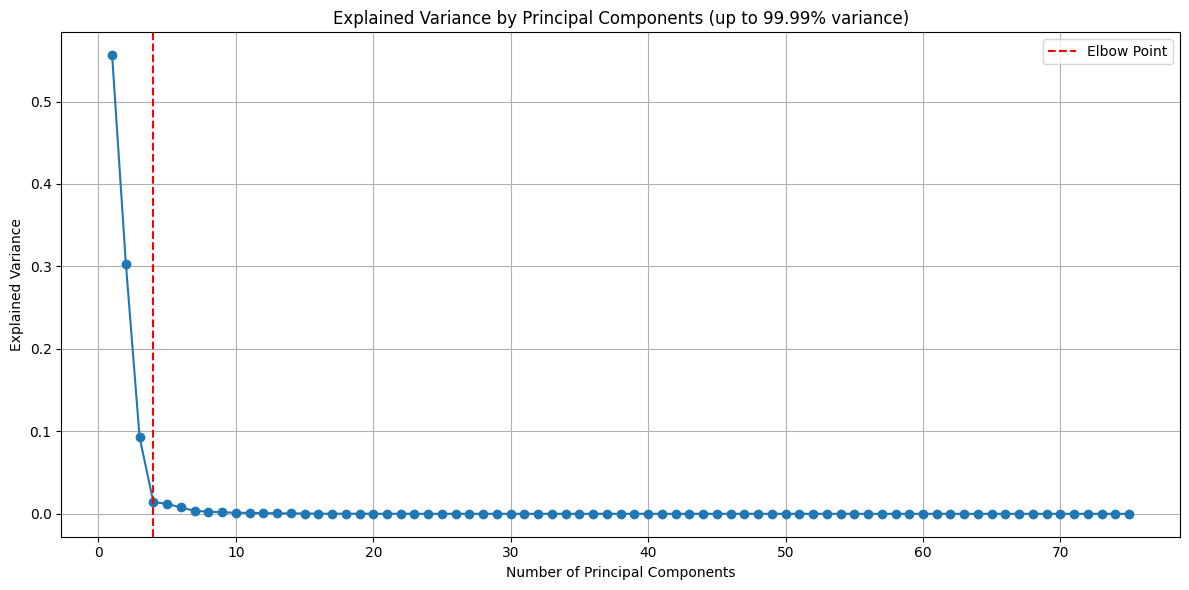

Explained Variance at Elbow Point (PC4): 0.0143


In [ ]:
# Fit PCA on scaled training data to determine number of components for 99.99% variance
pca_variance = PCA()
pca_variance.fit(train_x_scaled)

# Get explained variance ratios and cumulative variance
explained_variance = pca_variance.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find the number of components needed to explain 99.99% variance
threshold = 0.9999
num_components = np.argmax(cumulative_variance >= threshold) + 1  # +1 to include the component at the threshold

# Extract the explained variance for these components
explained_variance_selected = explained_variance[:num_components]

# Create DataFrame for the selected principal components
pca_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i + 1}' for i in range(num_components)],
    'Explained Variance': explained_variance_selected
})

# Print the pca_variance_df
print(pca_variance_df)

# Plot the explained variance for the selected components
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_components + 1), pca_variance_df['Explained Variance'], marker='o')
plt.title('Explained Variance by Principal Components (up to 99.99% variance)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')

# Use KneeLocator to find the elbow point
kneedle_variance = KneeLocator(
    x=np.arange(1, num_components + 1),  # PC numbers
    y=pca_variance_df['Explained Variance'],
    curve='convex',
    direction='decreasing'
)

variance_elbow_index = kneedle_variance.elbow
plt.axvline(x=variance_elbow_index, color='r', linestyle='--', label='Elbow Point')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the explained variance value at the elbow point
variance_elbow_value = pca_variance_df['Explained Variance'].iloc[variance_elbow_index - 1]  # Adjusting for zero indexing
print(f"Explained Variance at Elbow Point (PC{variance_elbow_index}): {variance_elbow_value:.4f}")


###2d: Using Biserial Correlation to Select Principal Components
In this section, we apply biserial correlation to the 75 principal components (PCs) generated from our PCA analysis. By calculating the absolute biserial correlation between each PC and the target variable, we identify PCs that are more directly related to the response variable. We then use the KneeLocator method to determine the elbow point in the correlation values, helping to select PCs with strong associations to the target variable, independent of their explained variance.
* `pca_biserial_df` is a dataframe containing each PC’s explained variance and absolute biserial correlation.
* `biserial_elbow_value` represents the biserial correlation at the elbow point
* The PCs 6, 17, 4, 18, 45, 19, 30, 67, 42, 13, 29 satisfy this criterion.

   Principal Component  Explained Variance  Absolute Biserial Correlation
5                  PC6            0.007757                       0.212852
16                PC17            0.000152                       0.185690
3                  PC4            0.014343                       0.167541
17                PC18            0.000134                       0.164225
44                PC45            0.000007                       0.119598
..                 ...                 ...                            ...
65                PC66            0.000002                       0.003946
24                PC25            0.000036                       0.003928
59                PC60            0.000003                       0.002799
37                PC38            0.000009                       0.002472
61                PC62            0.000003                       0.000740

[75 rows x 3 columns]


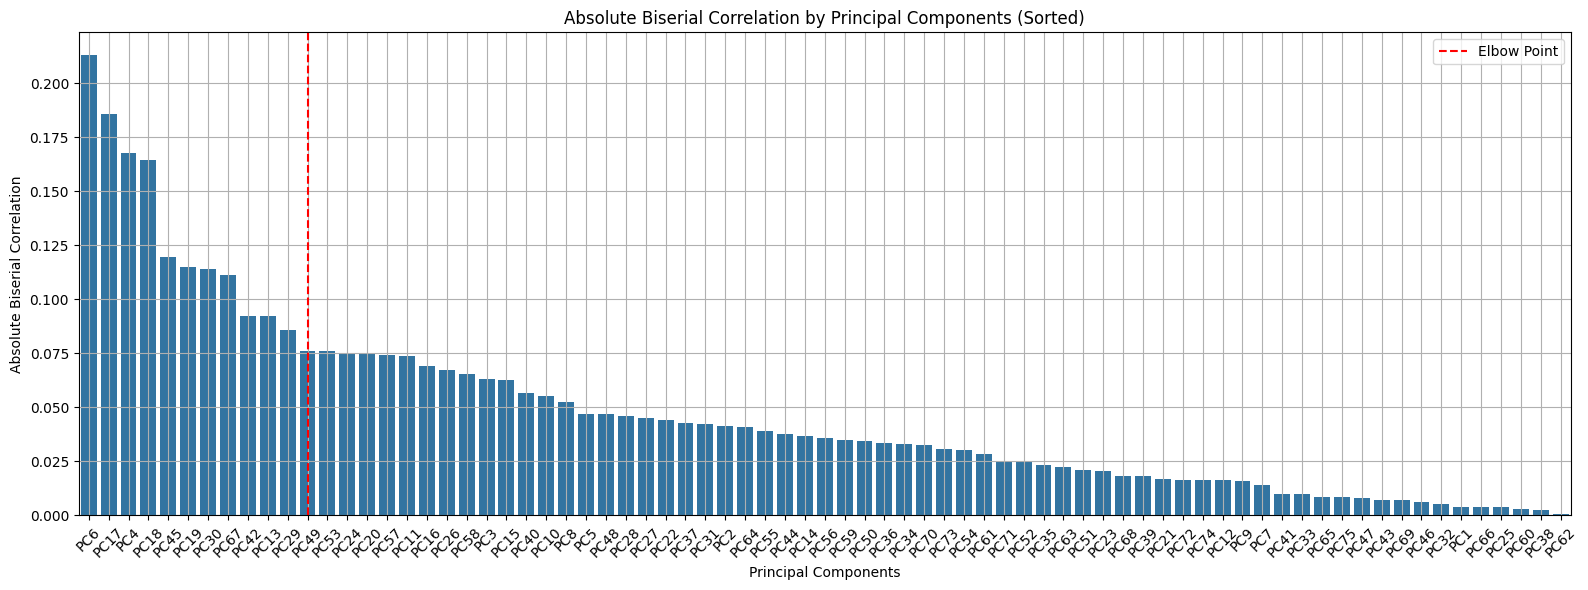

Absolute Biserial Correlation at Elbow Point (PC49): 0.0760


In [ ]:
# Perform PCA on the scaled training data to get 75 PCs
pca_components = PCA(n_components=75)
train_x_pca = pca_components.fit_transform(train_x_scaled)

# Calculate the absolute biserial correlation for each PC with respect to train_y
abs_biserial_correlations = np.abs([pointbiserialr(train_y.values, train_x_pca[:, i])[0] for i in range(train_x_pca.shape[1])])

# Create a new DataFrame for the biserial correlation data
pca_biserial_df = pca_variance_df.copy()  # Copy the variance DataFrame to avoid conflicts

# Add a new column for the Absolute Biserial Correlation to pca_biserial_df
pca_biserial_df['Absolute Biserial Correlation'] = abs_biserial_correlations[:num_components]  # Ensure it aligns with the number of components

# Sort the DataFrame by Absolute Biserial Correlation in descending order
pca_biserial_df.sort_values(by='Absolute Biserial Correlation', ascending=False, inplace=True)

# Print the sorted pca_biserial_df
print(pca_biserial_df)

# Plot the Absolute Biserial Correlation against Principal Components
plt.figure(figsize=(16, 6))
sns.barplot(x=pca_biserial_df['Principal Component'],
            y=pca_biserial_df['Absolute Biserial Correlation'],
            data=pca_biserial_df)

# Title and labels
plt.title('Absolute Biserial Correlation by Principal Components (Sorted)')
plt.xlabel('Principal Components')
plt.ylabel('Absolute Biserial Correlation')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Find the elbow point for Absolute Biserial Correlation using KneeLocator
kneedle_biserial = KneeLocator(
    x=np.arange(1, len(pca_biserial_df) + 1),  # PC numbers
    y=pca_biserial_df['Absolute Biserial Correlation'],
    curve='convex',
    direction='decreasing'
)

# Get the elbow index and highlight it on the plot
biserial_elbow_index = kneedle_biserial.elbow
plt.axvline(x=biserial_elbow_index - 1, color='red', linestyle='--', label='Elbow Point')  # -1 for zero indexing

# Legend and layout adjustments
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the Absolute Biserial Correlation value at the elbow point
biserial_elbow_value = pca_biserial_df['Absolute Biserial Correlation'].iloc[biserial_elbow_index - 1]  # Adjust for zero indexing

# Retrieve the corresponding principal component name from the sorted DataFrame
biserial_elbow_pc = pca_biserial_df['Principal Component'].iloc[biserial_elbow_index - 1]  # Adjust for zero indexing

# Print the Absolute Biserial Correlation value at the elbow point with the correct principal component label
print(f"Absolute Biserial Correlation at Elbow Point ({biserial_elbow_pc}): {biserial_elbow_value:.4f}")

###2e: Final Selection of Principal Components
This code block extracts the principal components that meet the established variance and biserial thresholds, providing a final selection of components relevant to both variance and correlation criteria. We fit PCA to the scaled training data, specifying the total number of components, then transform both the training and testing datasets. The transformed data is converted into DataFrames and filtered to retain only the selected components.
* The final selection includes PCs 1, 2, 3, 4, 6, 13, 17, 18, 19, 29, 30, 42, 45, 67
* `train_x_pca` is the transformed training data with selected principal components
* `test_x_pca` is the transformed testing data with selected principal components

In [ ]:
# Extract the principal components that meet the variance and biserial thresholds
selected_pcs_variance = pca_variance_df[pca_variance_df['Explained Variance'] > variance_elbow_value]['Principal Component'].tolist()
selected_pcs_biserial = pca_biserial_df[pca_biserial_df['Absolute Biserial Correlation'] > biserial_elbow_value]['Principal Component'].tolist()

# Combine the two lists to get the final selected components (without duplicates)
selected_pcs = list(set(selected_pcs_variance + selected_pcs_biserial))

# Print the list of selected principal components
print("Selected Principal Components (from variance and biserial):", selected_pcs)

# Define the number of principal components
n_pca = 75

# Fit PCA on scaled training data, specifying n_pca components
pca = PCA(n_components=n_pca)
train_x_pca = pca.fit_transform(train_x_scaled)

# Transform the scaled testing data using the same PCA object
test_x_pca = pca.transform(test_x_scaled)

# Convert the transformed data to DataFrames
train_x_pca = pd.DataFrame(train_x_pca, columns=[f'PC{i+1}' for i in range(n_pca)])
test_x_pca = pd.DataFrame(test_x_pca, columns=[f'PC{i+1}' for i in range(n_pca)])

# Filter train_x_pca and test_x_pca to keep only the principal components in selected_pcs
train_x_pca = train_x_pca[selected_pcs].reset_index(drop=True)
test_x_pca = test_x_pca[selected_pcs].reset_index(drop=True)

# Display the transformed data for verification
print("Dimensions of Transformed Training Data (PCA):", train_x_pca.shape)
print("Dimensions of Transformed Testing Data (PCA):", test_x_pca.shape)

# Display the first few rows of the transformed training data
print("Transformed Training Data (PCA):")
display(train_x_pca.head())

# Display the first few rows of the transformed testing data
print("Transformed Testing Data (PCA):")
display(test_x_pca.head())


Selected Principal Components (from variance and biserial): ['PC4', 'PC13', 'PC3', 'PC1', 'PC17', 'PC2', 'PC42', 'PC19', 'PC6', 'PC67', 'PC29', 'PC18', 'PC30', 'PC45']
Dimensions of Transformed Training Data (PCA): (841, 14)
Dimensions of Transformed Testing Data (PCA): (409, 14)
Transformed Training Data (PCA):


,PC4,PC13,PC3,PC1,PC17,PC2,PC42,PC19,PC6,PC67,PC29,PC18,PC30,PC45
0,1.321761,-0.348100,4.633988,-11.920993,-0.231239,-16.627108,-0.073025,0.071108,-1.051183,-0.013558,0.071937,0.089764,-0.048510,-0.034106
1,2.408925,-0.575143,10.453543,2.789459,-0.100458,-3.092281,-0.054491,0.173021,-5.425501,0.048093,0.169295,0.025300,0.023377,-0.068911
2,1.838161,0.336100,3.862780,-6.159038,-0.445895,0.287181,-0.073142,-0.160130,-2.226805,0.015146,0.009766,0.054907,0.044861,-0.019902
3,2.218899,-0.177037,-3.561962,-3.942046,0.122760,0.260335,-0.003083,-0.189889,0.925504,-0.040430,0.112436,-0.290106,0.098526,-0.033776
4,-1.313096,0.390529,-3.251258,-2.070923,-0.278569,11.327952,-0.079558,0.402777,0.300248,0.005250,0.129231,-0.493933,0.039378,-0.035887


Transformed Testing Data (PCA):


,PC4,PC13,PC3,PC1,PC17,PC2,PC42,PC19,PC6,PC67,PC29,PC18,PC30,PC45
0,1.337067,0.276152,-3.414171,8.628592,-0.169081,0.692069,-0.036832,0.148434,1.302735,0.027970,0.003347,-0.448544,-0.097384,0.063585
1,1.810872,0.113061,2.557429,-6.833175,-0.162307,1.735884,0.011752,0.113454,-1.894320,-0.068983,0.065850,0.404157,0.113149,-0.006552
2,0.191390,-0.022813,1.747069,14.259270,-0.064852,-4.160806,0.104165,0.323039,0.625582,0.048937,0.000858,-0.112639,0.096946,0.062287
3,1.252560,-0.127511,4.749285,-14.044921,0.144189,-14.320192,-0.054018,0.370927,-1.260503,-0.002844,0.094668,0.338627,0.037377,0.003626
4,2.684012,-0.616581,4.679345,-13.736146,-0.112605,-14.565481,-0.013070,0.253740,1.817723,-0.001367,0.040373,0.068207,0.026997,0.033093


###2f: Visualization of Selected Features with Response
We visualize the selected principal components using box plots to compare their distributions against the cancer status. We specifically chose PCs 1, 2, and 3, which exhibit high explained variance but low correlation with the target variable, alongside PCs 6, 17, and 45, which demonstrate low explained variance but high correlation. This dual approach highlights the comprehensiveness of our selection method, considering both explained variance and correlation with the response variable.

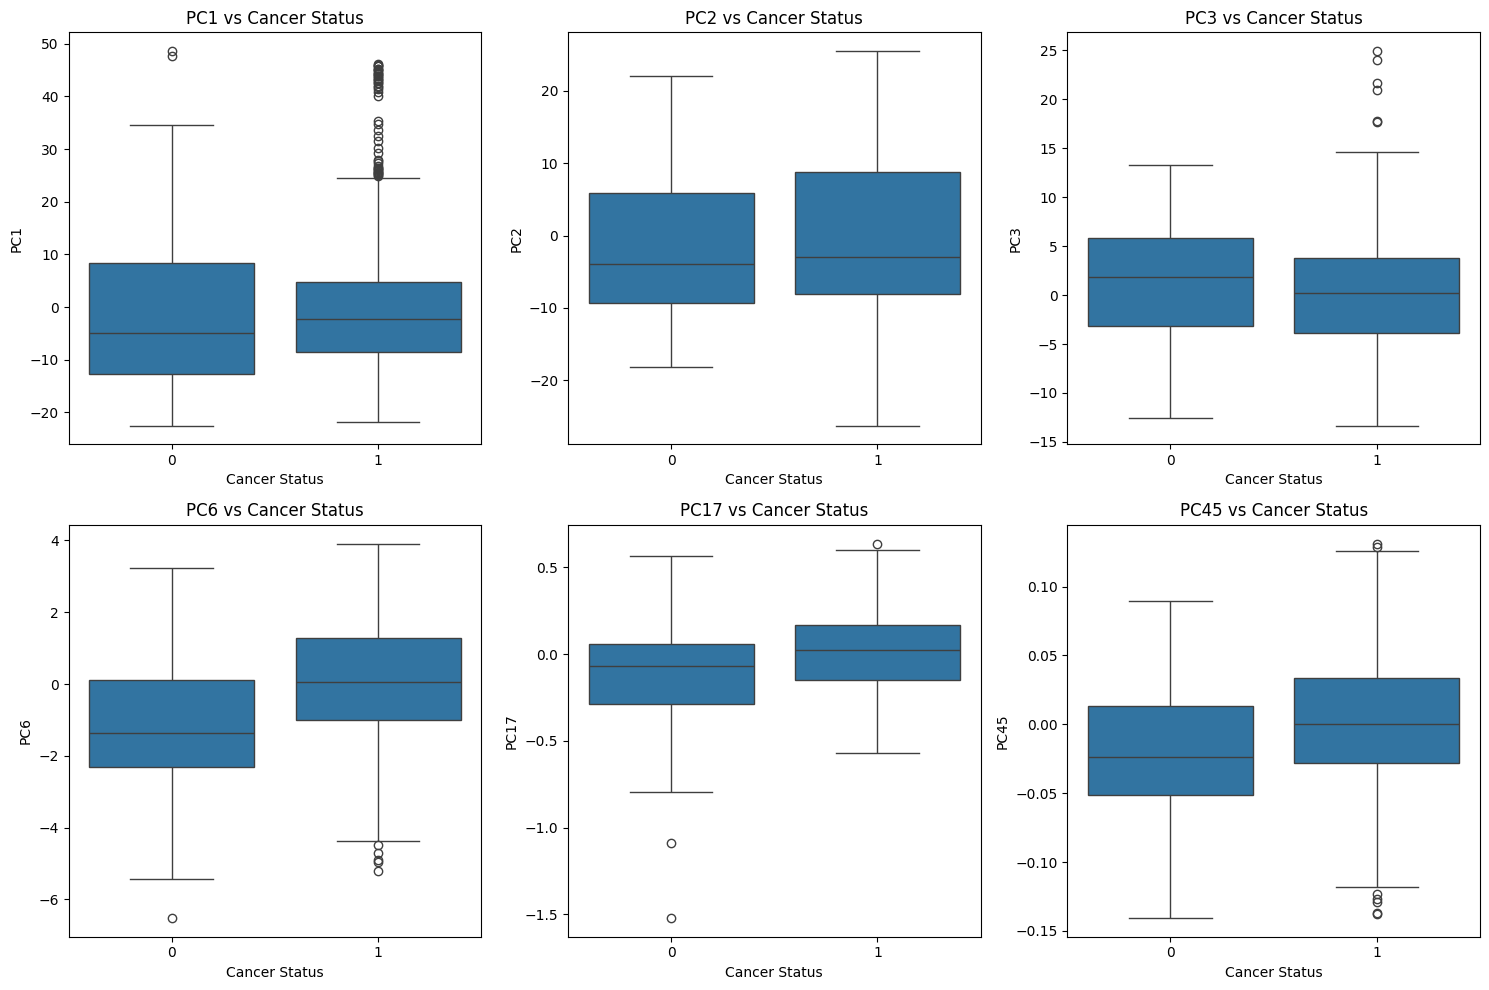

In [ ]:
# Specify the principal components you want to plot
selected_pcs_to_plot = ['PC1', 'PC2', 'PC3', 'PC6', 'PC17', 'PC45']

# Create box plots for the specified principal components
plt.figure(figsize=(15, 10))
num_rows = 2  # We need 2 rows (3x2 grid)

for i, pc in enumerate(selected_pcs_to_plot):  # Loop through the specified principal components
    plt.subplot(num_rows, 3, i + 1)  # Create subplots (3 columns, 2 rows)
    sns.boxplot(x=train_y, y=train_x_pca[pc])  # Reference the column by name
    plt.title(f'{pc} vs Cancer Status')  # Use the PC name in the title
    plt.xlabel('Cancer Status')  # Label for x-axis
    plt.ylabel(pc)  # Use the PC name for y-axis label

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Section 3: Model Training to Optimize Area Under Receiver Operating Curve

### 3a: SMOTE and K-Fold Cross Validation
In this section, we apply the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to address class imbalance in the dataset, followed by setting up a Stratified K-Fold cross-validation for model evaluation.

* `X_resampled` contains the resampled feature set after applying SMOTE to balance the classes.
* `y_resampled` represemts the resampled response variable corresponding to the balanced classes.
* `stratified_kf` initializes the Stratified K-Fold cross-validator, ensuring that each fold maintains the same class distribution as the entire dataset.

Additionally, we visualize the class distribution before and after applying SMOTE to confirm the effectiveness of the oversampling technique. We also verify the Stratified K-Fold setup by displaying the number of samples in each fold, ensuring balanced class representation.

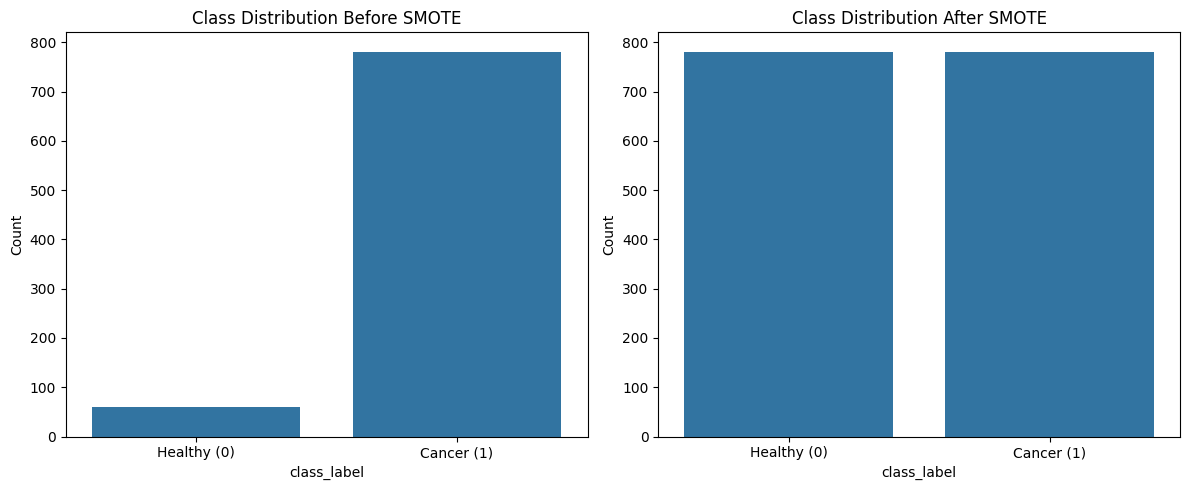

Fold 1:
  Training samples: 1249, Testing samples: 313
  Training class distribution: [624 625]
  Testing class distribution: [157 156]

Fold 2:
  Training samples: 1249, Testing samples: 313
  Training class distribution: [625 624]
  Testing class distribution: [156 157]

Fold 3:
  Training samples: 1250, Testing samples: 312
  Training class distribution: [625 625]
  Testing class distribution: [156 156]

Fold 4:
  Training samples: 1250, Testing samples: 312
  Training class distribution: [625 625]
  Testing class distribution: [156 156]

Fold 5:
  Training samples: 1250, Testing samples: 312
  Training class distribution: [625 625]
  Testing class distribution: [156 156]



In [ ]:
# Initialize SMOTE object using the imported package, random state = 1244 is the seed used to provide reproducibility
smote = SMOTE(random_state = 1244)
X_resampled, y_resampled = smote.fit_resample(train_x_pca, train_y)

# Initialize StratifiedKFold
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Visualize class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=train_y, ax=axes[0]) # sns.countplot creates the barplot
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Healthy (0)', 'Cancer (1)'])
axes[0].set_ylabel('Count')

# After SMOTE, both before and after plots help to verify that the imbalance is fixed
sns.countplot(x=y_resampled, ax=axes[1]) # sns.countplot creates the barplot
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Healthy (0)', 'Cancer (1)'])
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Verify Stratified K-Fold CV setup
folds = []
for train_index, test_index in stratified_kf.split(X_resampled, y_resampled):
    folds.append((train_index, test_index))

# Display the number of samples in each fold
for i, (train_idx, test_idx) in enumerate(folds):
    print(f"Fold {i + 1}:")
    print(f"  Training samples: {len(train_idx)}, Testing samples: {len(test_idx)}")
    print(f"  Training class distribution: {np.bincount(y_resampled[train_idx])}")
    print(f"  Testing class distribution: {np.bincount(y_resampled[test_idx])}\n")

### 3b: Logistic Regression Model Tuning
In this section, we perform hyperparameter tuning for the Logistic Regression model using GridSearchCV. We explore various combinations of parameters, including the inverse regularization strength CC, regularization type, solver options, maximum iterations, and class weights to address class imbalance. After fitting the model on the resampled dataset, we identify the best hyperparameters and their corresponding ROC-AUC score.
* `best_params_lr` contains the best hyperparameters for the Logistic Regression model.
* `best_score_lr` represents the best score for the Logistic Regression model.

In [ ]:
# Initialize a logistic regression model, use the same random state seed
log_reg = LogisticRegression(random_state = 1244)

# Define a parameter grid for hyperparameter tuning for the log reg model
param_grid_lr = {
    'C': [0.02, 0.04, 0.06, 0.08, 0.10],  # Inverse regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers that support L1 regularization
    'max_iter': [100, 200, 300, 400, 500],  # Number of iterations
    'class_weight': ['balanced']  # Handle class imbalance
}

# Set up GridSearchCV for the log reg model that uses ROC AUC as the evaluation metric
grid_search_lr = GridSearchCV(estimator=log_reg, param_grid=param_grid_lr, scoring='roc_auc', cv=stratified_kf, n_jobs=-1)

# Fit GridSearchCV on the resampled (balanced using SMOTE) training data to find the best hyperparameters
grid_search_lr.fit(X_resampled, y_resampled)

# Store the best parameters for logistic regression from the GridSearch
best_params_lr = grid_search_lr.best_params_ # Hyperparameters that gave the best model performance
best_score_lr = grid_search_lr.best_score_ # Best ROC AUC score from the grid search

print("Best Hyperparameters (Logistic Regression):", best_params_lr)
print("Best Score (Logistic Regression):", best_score_lr)

Best Hyperparameters (Logistic Regression): {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score (Logistic Regression): 0.919107599760466


### 3c: Random Forest Model Tuning
In this section, we conduct hyperparameter tuning for the Random Forest Classifier using GridSearchCV. We evaluate a range of hyperparameters, including the number of estimators, maximum depth, minimum samples for splitting and leaf nodes, maximum features, and criterion to optimize the model's performance while managing class imbalance. After fitting the model on the resampled dataset, we extract the best hyperparameters and their corresponding ROC-AUC score.
* `best_params_rf` contains the best hyperparameters for the Random Forest model.
* `best_score_rf` represents the best score for the Random Forest model.

In [ ]:
# Initialize a Random Forest classifier, use the same random state seed
rf = RandomForestClassifier(random_state = 1244)

# Define a parameter grid for hyperparameter tuning of the RF model
param_grid_rf = {
    'n_estimators': [5, 10, 15],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}

# Set up GridSearchCV for the RF model that uses ROC AUC as the evaluation metric
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='roc_auc', cv=stratified_kf, n_jobs=-1)

# Fit GridSearchCV on the resampled (balanced using SMOTE) training data to find the best hyperparameters
grid_search_rf.fit(X_resampled, y_resampled)

# Store the best parameters for Random Forest from the GridSearch
best_params_rf = grid_search_rf.best_params_ # Hyperparameters that gave the best model performance
best_score_rf = grid_search_rf.best_score_ # Best ROC AUC score from the grid search

print("Best Hyperparameters (Random Forest):", best_params_rf)
print("Best Score (Random Forest):", best_score_rf)

Best Hyperparameters (Random Forest): {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 15}
Best Score (Random Forest): 0.9924982830605075


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### 4d: Support Vector Machine Model Tuning
In this section, we perform hyperparameter tuning for the Support Vector Machine (SVM) model using GridSearchCV. We explore various hyperparameters, including the regularization parameter CC and different kernel types, while also addressing class imbalance. After fitting the SVM model to the resampled dataset, we identify the optimal hyperparameters and their corresponding ROC-AUC score.
* `best_params_svm` contains the best hyperparameters for the SVM model.
* `best_score_svm` represents the best score for the SVM model.

In [ ]:
# Initialize an SVM classifier, use the same random state seed
svm = SVC(random_state = 1244)

# Define a parameter grid for hyperparameter tuning of the SVM model
param_grid_svm = {
    'C': [4.0, 4.2, 4.4, 4.6, 4.8, 5.0],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'],  # Type of kernel to use
    'class_weight': ['balanced'],  # Handle class imbalance
}

# Set up GridSearchCV for the SVM model that uses ROC AUC as the evaluation metric
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, scoring='roc_auc', cv=stratified_kf, n_jobs=-1)

# Fit GridSearchCV on the resampled (balanced using SMOTE) training data to find the best hyperparameters
grid_search_svm.fit(X_resampled, y_resampled)

# Store the best parameters for SVM from the GridSearch
best_params_svm = grid_search_svm.best_params_ # Hyperparameters that gave the best model performance
best_score_svm = grid_search_svm.best_score_ # Best ROC AUC score from the grid search

print("Best Hyperparameters (SVM):", best_params_svm)
print("Best Score (SVM):", best_score_svm)

Best Hyperparameters (SVM): {'C': 4.6, 'class_weight': 'balanced', 'kernel': 'linear'}
Best Score (SVM): 0.9548978839767669


# Section 4: Model Testing & Evaluation
Finally, we employed the best hyperparameters identified earlier to evaluate the performance of three models (Logistic Regression, Random Forest, and Support Vector Machine) on new, unseen testing data. For each model, we assessed their performance by analyzing the ROC and Precision-Recall curves. The results are compiled into `results_df`.


                    Model  Train ROC AUC  Test ROC AUC  \
0     Logistic Regression       0.919108      0.856906   
1           Random Forest       0.992498      0.883749   
2  Support Vector Machine       0.954898      0.881959   

   Test Precision-Recall AUC  
0                   0.978940  
1                   0.984736  
2                   0.981956  


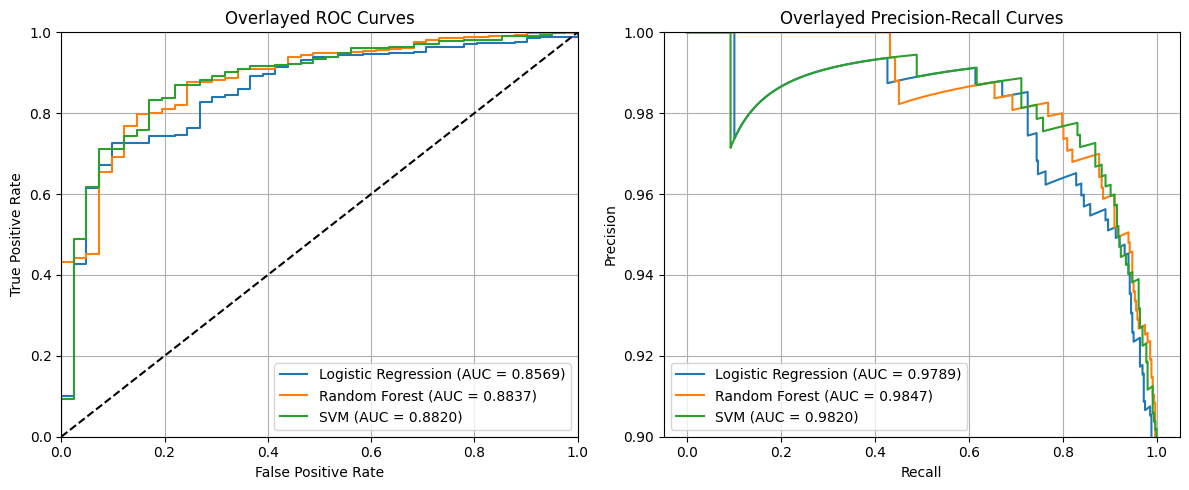

In [ ]:
# Evaluating Logistic Regression
log_reg = LogisticRegression(random_state = 1244, **best_params_lr)  # Initialize Logistic Regression model with best parameters
log_reg.fit(X_resampled, y_resampled)  # Fit the model on the resampled training data

y_scores_lr = log_reg.predict_proba(test_x_pca)[:, 1]  # Get predicted probabilities for the positive class
precision_lr, recall_lr, _ = precision_recall_curve(test_y, y_scores_lr)  # Compute precision and recall values
auc_pr_lr = auc(recall_lr, precision_lr)  # Calculate the area under the precision-recall curve
fpr_lr, tpr_lr, _ = roc_curve(test_y, y_scores_lr)  # Compute ROC curve
roc_auc_lr = auc(fpr_lr, tpr_lr)  # Calculate the area under the ROC curve

# Evaluating Random Forest
rf = RandomForestClassifier(random_state = 1244, **best_params_rf)  # Initialize Random Forest model with best parameters
rf.fit(X_resampled, y_resampled)  # Fit the model on the resampled training data

y_scores_rf = rf.predict_proba(test_x_pca)[:, 1]  # Get predicted probabilities for the positive class
precision_rf, recall_rf, _ = precision_recall_curve(test_y, y_scores_rf)  # Compute precision and recall values
auc_pr_rf = auc(recall_rf, precision_rf)  # Calculate the area under the precision-recall curve
fpr_rf, tpr_rf, _ = roc_curve(test_y, y_scores_rf)  # Compute ROC curve
roc_auc_rf = auc(fpr_rf, tpr_rf)  # Calculate the area under the ROC curve

# Evaluating Support Vector Machine
svm = SVC(random_state = 1244, **best_params_svm, probability=True)  # Initialize SVM model with best parameters and enable probability estimates
svm.fit(X_resampled, y_resampled)  # Fit the model on the resampled training data

y_scores_svm = svm.predict_proba(test_x_pca)[:, 1]  # Get predicted probabilities for the positive class
precision_svm, recall_svm, _ = precision_recall_curve(test_y, y_scores_svm)  # Compute precision and recall values
auc_pr_svm = auc(recall_svm, precision_svm)  # Calculate the area under the precision-recall curve
fpr_svm, tpr_svm, _ = roc_curve(test_y, y_scores_svm)  # Compute ROC curve
roc_auc_svm = auc(fpr_svm, tpr_svm)  # Calculate the area under the ROC curve

# Combine results into a DataFrame with specified columns
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Support Vector Machine'],  # Model names
    'Train ROC AUC': [best_score_lr, best_score_rf, best_score_svm],  # Training AUC scores for each model
    'Test ROC AUC': [roc_auc_lr, roc_auc_rf, roc_auc_svm],  # Test AUC scores for each model
    'Test Precision-Recall AUC': [auc_pr_lr, auc_pr_rf, auc_pr_svm],  # AUC values for Precision-Recall curves
})

print(results_df)  # Display the combined results of all models

# Plotting Overlayed Precision-Recall and ROC Curves for all models
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.4f})'.format(roc_auc_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.4f})'.format(roc_auc_rf))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.4f})'.format(roc_auc_svm))
plt.title('Overlayed ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.legend()

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, label='Logistic Regression (AUC = {:.4f})'.format(auc_pr_lr))
plt.plot(recall_rf, precision_rf, label='Random Forest (AUC = {:.4f})'.format(auc_pr_rf))
plt.plot(recall_svm, precision_svm, label='SVM (AUC = {:.4f})'.format(auc_pr_svm))
plt.title('Overlayed Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0.9, 1)
plt.grid()
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the combined plots
